# **Importing Dependencies**

In [1]:
import os
from typing import Any
import nltk
import nltk.internals
import pandas as pd

In [2]:
from pydantic import BaseModel
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

# **Loading the Interviews and Pre-Processing them**


## **Reading interviews from text files**

In [1]:
# interviews =[]
# for i in range(9):
#     with open(f"Deidentified_parents_interview_{i+1}.txt", "r", encoding='utf8') as fp:
#         interview = fp.read()
#         interviews.append(interview)
# interviews

In [4]:
for i in range(9):
    print(len(interviews[i].split()))

11688
12575
11774
11457
11115
10908
8936
12664
7767


## **Splitting text into smaller chunks**

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 800000,
    separators=["\n\n","\n", "Interviewer"],
    length_function=len,
    is_separator_regex=False
)

In [6]:
collection=[]
for interview in interviews:
    doc = text_splitter.create_documents([interview])
    collection.append(doc)

In [7]:
def format_docs(collection):
    texts=[]
    for docs in collection:
        for doc in docs:
            texts.append(doc.page_content)
    return texts

texts = format_docs(collection)

In [8]:
texts

['Interviewer: ... that as a no. Okay, great. Just even before we start with you all introducing yourselves, I guess my first question is that in this project thus far, you know, we and, I guess, providers and people clinically, the way that they refer to this type of heart condition is as anomalous aortic origin of a coronary artery, the acronym being AAOCA. I guess, before we get started, I just wanted to ask you all: Is that what you all call it? Or how do you refer to this condition?\nParticipant_1001: The same. My daughter got very proficient in using the acronym, and she knows what it stands for, and we also say, "AAOCA" and "ALCA," which is the anomalous left coronary artery, because that is where she had her defect.\nInterviewer: Okay. Cool.\nParticipant_1002: So, my case, instead of the left, it\'s the right coronary artery for my son, anomalous right coronary artery, so he has abnormal origin of the RCA.\nInterviewer: Okay.\nParticipant_1002: Yeah.\nParticipant_2003: I actual

# **Extracting codes from the interviews**

In [9]:
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

In [10]:
class Themes(BaseModel):
    Name: str
    Description: str
    Quote: str

parser = JsonOutputParser(pydantic_object=Themes)

In [11]:
open_api_key = ""
os.environ["OPENAI_API_KEY"]=open_api_key
# model_name = "gpt-4o"
model_name = "gpt-4o-mini"
model = ChatOpenAI(model_name = model_name, temperature = 1)

In [13]:
prompt_text = """
### System: You are a professional sociologist, when you read the text you recognize themes and relationships. When asked to compare concepts you are able to recognize connections that are abstract or conceptual

### User:
Identify all themes in the text, provide a name for each theme in no more than 5 words, a condensed description of the theme, and a quote from the interview that supports the theme.

Format the response as a JSON output keeping names, descriptions and quotes together in the JSON, and keep them together in 'Themes'.
The response should start from 'Themes' as a JSON output
text: {text}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

LLMchain = {"text": lambda x:x} | prompt | model | parser

In [14]:
themes = LLMchain.batch(texts, {"max_concurrency": 20})

In [15]:
themes

[{'Themes': [{'name': 'Terminology and Communication',
    'description': 'Participants discuss how they refer to the condition and simplify it for others.',
    'quote': "We've been similar to what is saying, simply because a lot of people, even some of the medical practitioners, have no idea of what we're talking about."},
   {'name': 'Parenting Challenges',
    'description': "Parents navigate the complexities of discussing their child's condition with them and others.",
    'quote': "Just his heart condition, that's really all we say about it."},
   {'name': 'Emotional Toll',
    'description': "The emotional strain of managing a child's health and the unknowns associated with their condition.",
    'quote': "It's very emotional, it's always wondering."},
   {'name': 'Surgery Decision-Making',
    'description': 'Discussions on the difficult choices parents face regarding surgery for their children.',
    'quote': "It’s like, are we the parents that should be responsible for that b

In [16]:
# collections = [parser.invoke(theme)['Themes'] for theme in themes]
collections = [theme['Themes'] for theme in themes]
list_of_codes = []
for codes in collections:
    for code in codes:
        list_of_codes.append(code)

In [17]:
df_codes = pd.DataFrame(columns=['Code','Description','Quote'])
for i,code in enumerate(list_of_codes):
        df_codes.loc[i,'Code'] = code.get('name') or code.get('Name')
        df_codes.loc[i,'Description'] = code.get('description') or code.get('Description')
        df_codes.loc[i,'Quote'] = code.get('quote') or code.get('Quote')

df_codes

,Code,Description,Quote
0,Terminology and Communication,Participants discuss how they refer to the con...,"We've been similar to what is saying, simply b..."
1,Parenting Challenges,Parents navigate the complexities of discussin...,"Just his heart condition, that's really all we..."
2,Emotional Toll,The emotional strain of managing a child's hea...,"It's very emotional, it's always wondering."
3,Surgery Decision-Making,Discussions on the difficult choices parents f...,"It’s like, are we the parents that should be r..."
4,Information Gaps,Participants express frustration over the lack...,It's so frustrating to know that there is no d...
...,...,...,...
75,Emotional Connection,Participants reflect on the emotional toll and...,our pediatrician is wonderful but I do think w...
76,Advocacy and Support,Parents emphasize the importance of advocacy a...,it would be nice to know other parents who are...
77,Desire for Early Detection,A call for improved health practices for early...,I think we should have a schedule for EKGs and...
78,Coping with Emotional Stress,Parents discuss various coping mechanisms and ...,"I'm a big proponent of therapy, and I am lucky..."


In [18]:
# get a time stamp for the file name
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
df_codes.to_csv(f"df_codes_parents_baseline_full_{now}_{model_name}.csv", index=False)

## **Finding major themes from the unique codes**

In [19]:
class Groups(BaseModel):
    Group: str
    Description: str
    # Original_Topics: list[str]
    
parser = JsonOutputParser(pydantic_object=list[Groups])

In [20]:
# Prompt for generating initial themes from each chunk
chunk_prompt_template = """
### System: You are a professional sociologist, when you read the text you recognize themes and relationships. When asked to compare concepts you are able to recognize connections that are abstract or conceptual.
### User:
Determine how all the topics in the list of topics can be grouped together. Topics can be in more than one group. Provide a name and description for each group.

Format the response as a JSON output, keeping Name and Description under 'Groups' together in the JSON.

text = {text}
"""
chunk_prompt = ChatPromptTemplate.from_template(chunk_prompt_template)

In [21]:
# Function to format data for the prompt
def format_dataframe(df):
    text = ""
    for _, row in df.iterrows():
        text += f"Topics: {row['Code']}, Description: {row['Description']}\n"
    return text

# Step 1: Split data into chunks
chunk_size = 1000  # Adjust based on input length limits and complexity
chunks = [df_codes[i:i + chunk_size] for i in range(0, len(df_codes), chunk_size)]

In [22]:
chunks_3 = chunks * 3

In [28]:
# Step 2: Process each chunk independently to gather preliminary themes
all_initial_themes = []
for chunk in chunks_3:
    text = format_dataframe(chunk)
    # Process each chunk to generate preliminary themes
    response = chunk_prompt | model | parser
    chunk_themes = response.invoke({"text": text}, max_concurrency=20)
    print(chunk_themes)

    if isinstance(chunk_themes, dict) and "Groups" in chunk_themes:
        chunk_themes = chunk_themes["Groups"]
        all_initial_themes.append(chunk_themes)
    elif isinstance(chunk_themes, dict) and "groups" in chunk_themes:
        chunk_themes = chunk_themes["groups"]
        all_initial_themes.append(chunk_themes)
    else:
        print("Unexpected response format:", chunk_themes)
        all_initial_themes.append(chunk_themes)

{'Groups': [{'Name': 'Communication and Information', 'Description': 'This group encompasses the various aspects of discussing medical conditions, information dissemination, and the complexities that arise in understanding and conveying medical terms and experiences.'}, {'Name': 'Parental Challenges and Emotional Impact', 'Description': 'This group focuses on the emotional and psychological toll faced by parents as they navigate the health challenges of their children, including anxiety, stress, and the need for strong support systems.'}, {'Name': 'Healthcare Decision-Making', 'Description': 'This group covers the processes and difficulties involved in making healthcare decisions for children, including surgery, treatment options, and the necessity of seeking second opinions.'}, {'Name': 'Support Systems and Community', 'Description': "This group highlights the importance of familial and community support in coping with children's health issues and the shared experiences that foster re

In [29]:
# groups = [group for sublist in all_initial_themes for group in parser.invoke(sublist)['Groups']]
groups = [group for sublist in all_initial_themes for group in sublist]
for group in groups:
    print(group)

{'Name': 'Communication and Information', 'Description': 'This group encompasses the various aspects of discussing medical conditions, information dissemination, and the complexities that arise in understanding and conveying medical terms and experiences.'}
{'Name': 'Parental Challenges and Emotional Impact', 'Description': 'This group focuses on the emotional and psychological toll faced by parents as they navigate the health challenges of their children, including anxiety, stress, and the need for strong support systems.'}
{'Name': 'Healthcare Decision-Making', 'Description': 'This group covers the processes and difficulties involved in making healthcare decisions for children, including surgery, treatment options, and the necessity of seeking second opinions.'}
{'Name': 'Support Systems and Community', 'Description': "This group highlights the importance of familial and community support in coping with children's health issues and the shared experiences that foster resilience and un

In [30]:
# Step 3: reflect
reflect_prompt_template = """
### System: You are a professional sociologist, when you read the text you recognize themes and relationships. When asked to compare concepts you are able to recognize connections that are abstract or conceptual.
### User:
Given the following list of topics,
Topics: {topic_text}

Determine how all the topics in the list of topics can be grouped together. Topics can be in more than one group. Provide a name and description for each group.

themes_text = {themes_text}

List the flaws and faulty logic of each name-description pair. Let's work this out in a step by step way to be sure we have all the errors.

Format the response as a JSON output with groups, each containing the name, description, and flaws.
"""
reflect_prompt = ChatPromptTemplate.from_template(reflect_prompt_template)

In [31]:
# Prepare input for the consolidation step
themes_text = "\n".join([f"Theme: {theme['Name']}, Description: {theme['Description']}" for 
                                sublist in all_initial_themes for theme in sublist])

In [32]:
themes_text

"Theme: Communication and Information, Description: This group encompasses the various aspects of discussing medical conditions, information dissemination, and the complexities that arise in understanding and conveying medical terms and experiences.\nTheme: Parental Challenges and Emotional Impact, Description: This group focuses on the emotional and psychological toll faced by parents as they navigate the health challenges of their children, including anxiety, stress, and the need for strong support systems.\nTheme: Healthcare Decision-Making, Description: This group covers the processes and difficulties involved in making healthcare decisions for children, including surgery, treatment options, and the necessity of seeking second opinions.\nTheme: Support Systems and Community, Description: This group highlights the importance of familial and community support in coping with children's health issues and the shared experiences that foster resilience and understanding among parents.\nTh

In [33]:
topic_text = format_dataframe(df_codes)
topic_text

"Topics: Terminology and Communication, Description: Participants discuss how they refer to the condition and simplify it for others.\nTopics: Parenting Challenges, Description: Parents navigate the complexities of discussing their child's condition with them and others.\nTopics: Emotional Toll, Description: The emotional strain of managing a child's health and the unknowns associated with their condition.\nTopics: Surgery Decision-Making, Description: Discussions on the difficult choices parents face regarding surgery for their children.\nTopics: Information Gaps, Description: Participants express frustration over the lack of available data and information about the condition.\nTopics: Support Systems, Description: Importance of having a support network to cope with the child's health issues.\nTopics: Awareness and Advocacy, Description: A call for increased awareness and advocacy regarding congenital heart conditions.\nTopics: Living with Uncertainty, Description: The continuous unce

In [34]:
# Create final prompt for consolidation
reflect_response = reflect_prompt | model | parser
reflect_themes = reflect_response.invoke({"topic_text": topic_text, "themes_text": themes_text}, max_concurrency=20)

In [35]:
reflect_themes

{'groups': [{'name': 'Communication and Information',
   'description': 'This group encompasses the various aspects of discussing medical conditions, information dissemination, and the complexities that arise in understanding and conveying medical terms and experiences.',
   'flaws': ['The group name is identical to subsequent themes, leading to confusion and redundancy.',
    'The description lacks specificity regarding which aspects of communication are addressed and does not distinguish between medical terminology and general discussions.',
    'It does not mention the emotional implications of communication breakdowns, which are often central to these discussions.']},
  {'name': 'Parental Challenges and Emotional Impact',
   'description': 'This group focuses on the emotional and psychological toll faced by parents as they navigate the health challenges of their children, including anxiety, stress, and the need for strong support systems.',
   'flaws': ['The description overlaps si

In [36]:
# Step 3: reflect
final_prompt_template = """
### System: You are a professional sociologist, when you read the text you recognize themes and relationships. When asked to compare concepts you are able to recognize connections that are abstract or conceptual.
### User:
Given the following list of topics,
Topics: {topic_text}

Determine how all the topics in the list of topics can be grouped together. Topics can be in more than one group. Provide a name and description for each group.

themes_text = {themes_text}

List the flaws and faulty logic of each name-description pair.
Let's work this out in a step by step way to be sure we have all the errors.

flaws_text = {flaws_text}

You are a resolver tasked with finding the answers that best determines how all the topics in the list of topics can be grouped together.
1)removing any redundant or duplicate groups.
2)improving the names and descriptions based on the analysis of flaws
3) printing the improved group names and descriptions in full.
Let's work this one out in a step by step way:

Give 12 groups that best represent the topics.
Each final group should have a description of 60 to 80 words
Format the response as a JSON output with major groups, each containing the name and Description.
"""
final_prompt = ChatPromptTemplate.from_template(final_prompt_template)

In [37]:
flaws_text = "\n".join([f"Theme: {flaw['name']}. Description: {flaw['description']}. Flaws: {flaw['flaws']}"  for flaw in reflect_themes['groups']])

In [38]:
final_response = final_prompt | model | parser
final_themes = final_response.invoke({"topic_text": topic_text, "themes_text": themes_text, "flaws_text": flaws_text}, max_concurrency=20)

In [39]:
final_themes

{'groups': [{'name': 'Communication and Information Sharing',
   'description': 'This group focuses on the critical aspects of effectively communicating medical conditions, overcoming information gaps, and the emotional impact of communication breakdowns. It emphasizes the need for clear terminology, transparent discussions with healthcare providers, and fostering understanding among families and the broader community about congenital heart conditions.'},
  {'name': 'Parental Emotional Challenges',
   'description': "This group addresses the emotional and psychological toll experienced by parents navigating their child's health challenges. It highlights anxiety, stress, and the necessity for robust support systems, emphasizing the importance of mental health awareness, coping strategies, and the emotional burden imposed by uncertainty and decision-making in healthcare contexts."},
  {'name': 'Healthcare Decision-Making',
   'description': 'This group covers the complexities surrounding

In [40]:
collections = final_themes['groups']
df_themes = pd.DataFrame(columns=['Theme','Description'])
for i,theme in enumerate(collections):
    df_themes.loc[i,'Theme'] = theme['name']
    df_themes.loc[i,'Description'] = theme['description']

df_themes

,Theme,Description
0,Communication and Information Sharing,This group focuses on the critical aspects of ...
1,Parental Emotional Challenges,This group addresses the emotional and psychol...
2,Healthcare Decision-Making,This group covers the complexities surrounding...
3,Support Systems and Community Engagement,This group emphasizes the vital role of famili...
4,Living with Uncertainty and Long-Term Health M...,This group addresses the continual uncertainti...
5,Children’s Experiences and Mental Health,This group focuses on the lived experiences of...
6,Advocacy and Awareness for Health Outcomes,This group addresses the importance of advocac...
7,Impact of Health Conditions on Family Dynamics,This group examines how a child's health condi...
8,Mental Health and Emotional Support,This group explores the vital need for mental ...
9,Complexities of Healthcare Navigation,This group highlights the various challenges f...


In [41]:
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
df_themes.to_csv(f"df_themes_parents_baseline_full_{now}_{model_name}_long.csv", index=False)

In [42]:
quit()

## **Comparison with annotated themes developed by humans**

In [43]:
with open("AAOCA_Parents_outcomes_themes.txt",
          encoding='utf8') as fp:
    human_themes = fp.read()

In [44]:
with open("AAOCA_Parents_outcomes.txt",
          encoding='utf8') as fp:
    human_themes_description = fp.read()

In [45]:
human_themes_split = human_themes.split('\n\n')
descriptions_split = human_themes_description.split("\n\n")

In [46]:
df_human_themes = pd.DataFrame(columns=['Theme','Description', 'Codes'])
for i,theme in enumerate(human_themes_split):
    theme_split = theme.split(':')
    df_human_themes.loc[i,'Codes'] = theme_split[1].split('\n')[1:]

In [47]:
# length = 0
# for codes in df_themes['Original_Codes']:
#     length += len(codes)

# length

In [48]:
indexes = [11,6,10,1,4,5,8,2,7,0,9,3]

In [49]:
for i,(ind,description) in enumerate(zip(indexes,descriptions_split)):
    description_split = description.split(":\n")
    # print(description_split)
    df_human_themes.loc[ind, 'Theme']=description_split[0]
    df_human_themes.loc[ind, 'Description']=description_split[1]

In [ ]:
df_human_themes

,Theme,Description,Codes
0,Clarity of potential risks and outcomes,While acknowledging the current challenges of ...,"[Fear of cardiac events, Uncertainty of future..."
1,Freedom from hypervigilance related to the con...,A dominating sense of hypervigilance was descr...,"[Fear of cardiac events, Parents always on, Un..."
2,The diagnosis given in a compassionate and emp...,While the diagnosis experience was minimally d...,"[Diagnosis as traumatic and frightening, Diagn..."
3,A sense of control over the future,Receiving the diagnosis of AAOCA for their chi...,"[Lack of control over outcomes for child, Unce..."
4,Being heard and taken seriously by clinicians,"As with individuals with AAOCA, parents expres...",[Frequent challenges within the diagnostic jou...
5,Individualized support for management decision...,Similar to individuals with a diagnosis of AAO...,"[Decision between intervention and limitation,..."
6,Receiving support from others,"As in individuals with a diagnosis of AAOCA, p...",[Importance of support from family and friends...
7,Being appropriately informed,Parents also endorsed the importance of feelin...,"[Searching for answers on own, Trying to under..."
8,Partnership with the care team,Being a partner with the care team was also im...,[Importance of clinician relationships and int...
9,Feeling that my child is safe,Their child’s safety was of great importance t...,"[Planning for adverse events, Parents always o..."


: 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util

d:\software-acsii\mini\envs\daily\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluation

# all-mpnet-base-v2

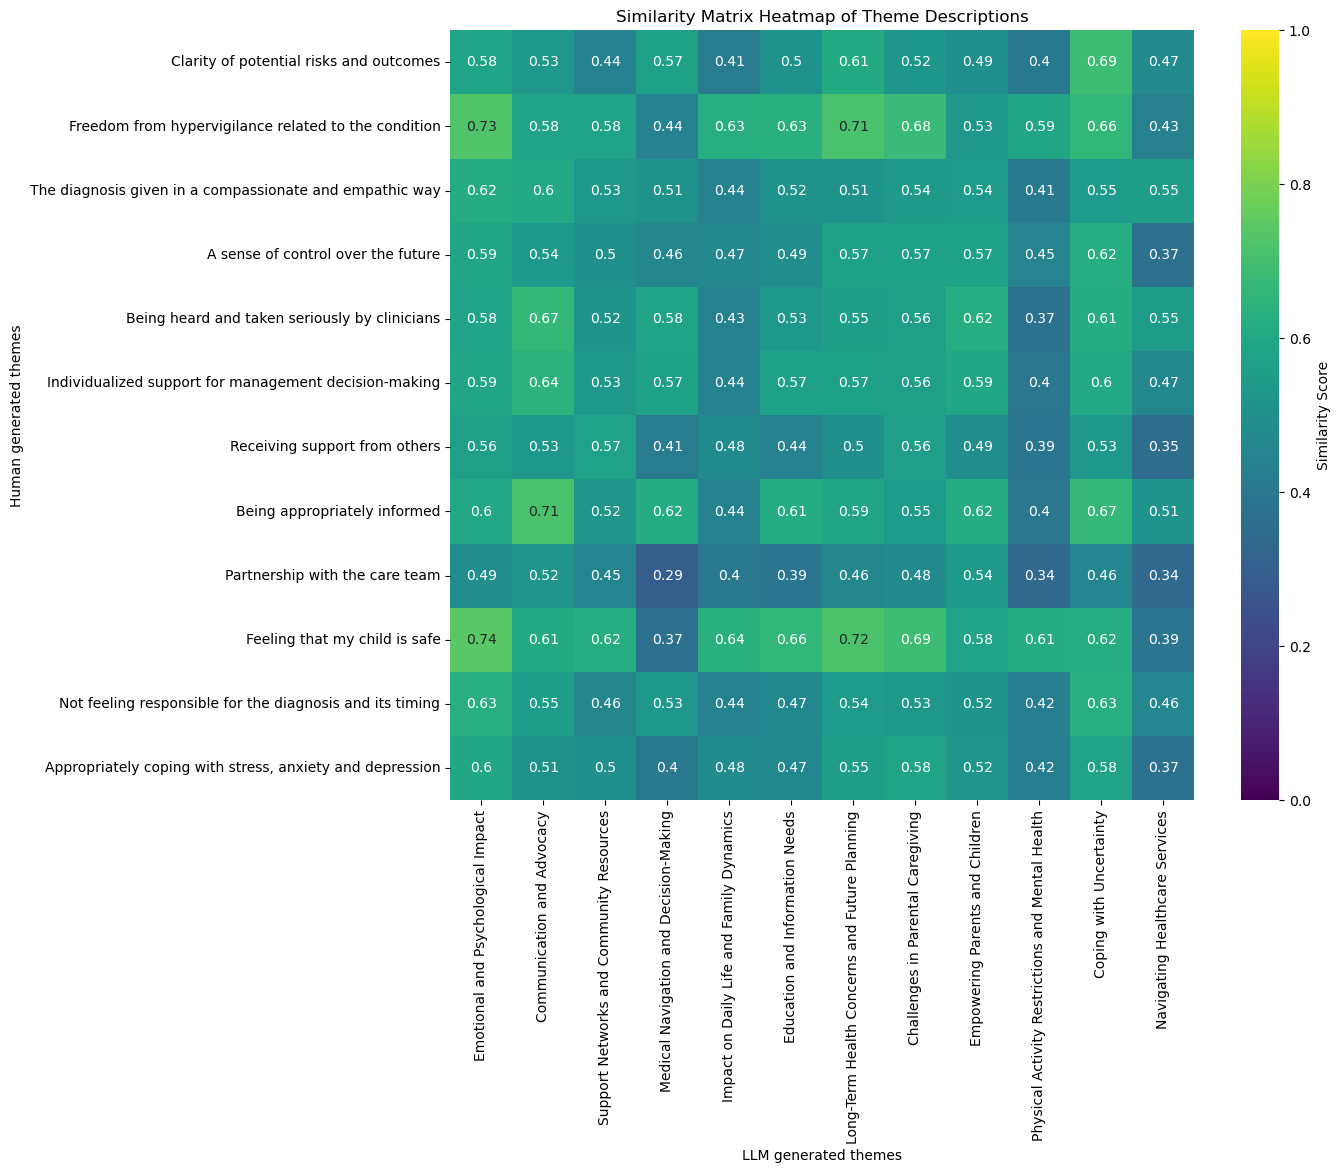

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name_eval = "all-mpnet-base-v2"
model = SentenceTransformer('all-mpnet-base-v2')

human_desc_embeddings = model.encode(df_human_themes['Description'].tolist(), convert_to_tensor=True)
llm_desc_embeddings = model.encode(df_themes['Description'].tolist(), convert_to_tensor=True)

cosine_sim_matrix = util.pytorch_cos_sim(human_desc_embeddings,llm_desc_embeddings).numpy()

similarity_desc_df = pd.DataFrame(
    cosine_sim_matrix,
    index = df_human_themes['Theme'],
    columns = df_themes['Theme']
)
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('Similarity Matrix Heatmap of Theme Descriptions')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [ ]:
import numpy as np
threshold = np.quantile(similarity_desc_df, 0.80)
threshold

0.607781708240509

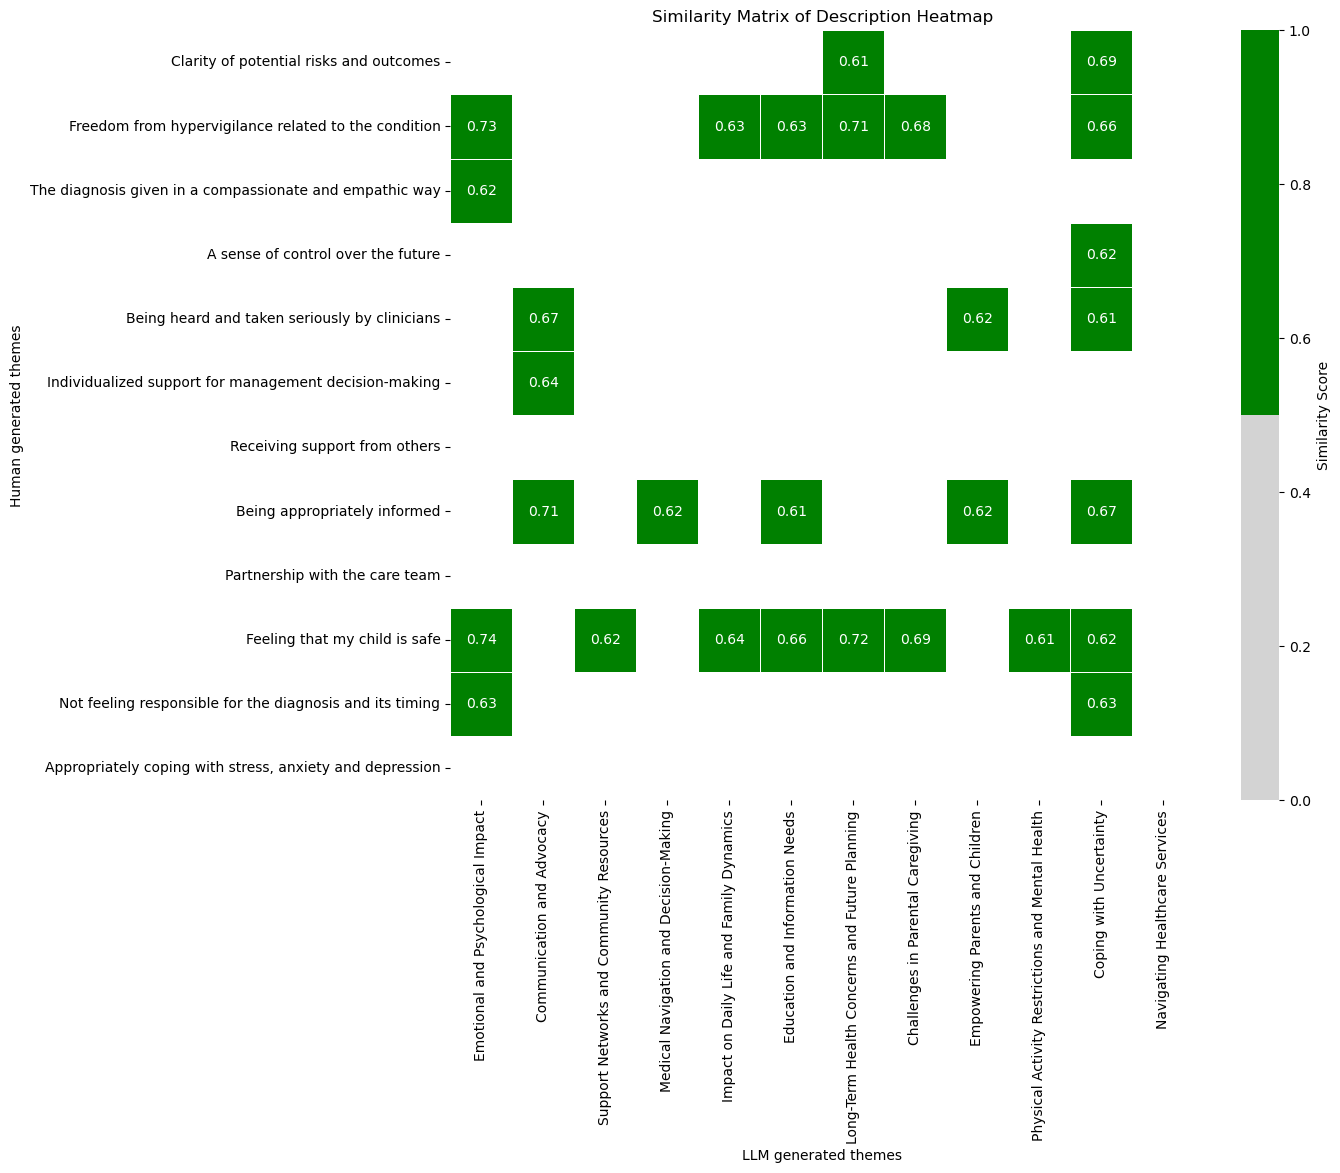

In [ ]:
from matplotlib.colors import ListedColormap

threshold = np.quantile(similarity_desc_df, 0.80)
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_desc_df <= threshold),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('Similarity Matrix of Description Heatmap')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [ ]:
print(f'{model_name_eval} Threshold: {round(threshold,2)}')
similarity_array = similarity_desc_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array >= .6198)
percent_high = (high_similarity_count/total_cells)
print(f"Jarcard. {round(percent_high,3)}")

similarity_array = similarity_desc_df.to_numpy()
total_hit = np.sum(np.any(similarity_array >= .6198, axis=1).astype(int))
hit_rate = total_hit/len(df_human_themes)
print(f"Hit Rate. {round(hit_rate,3)}")

all-mpnet-base-v2 Threshold: 0.61
Jarcard. 0.139
Hit Rate. 0.583


# all-MiniLM-L6-v2

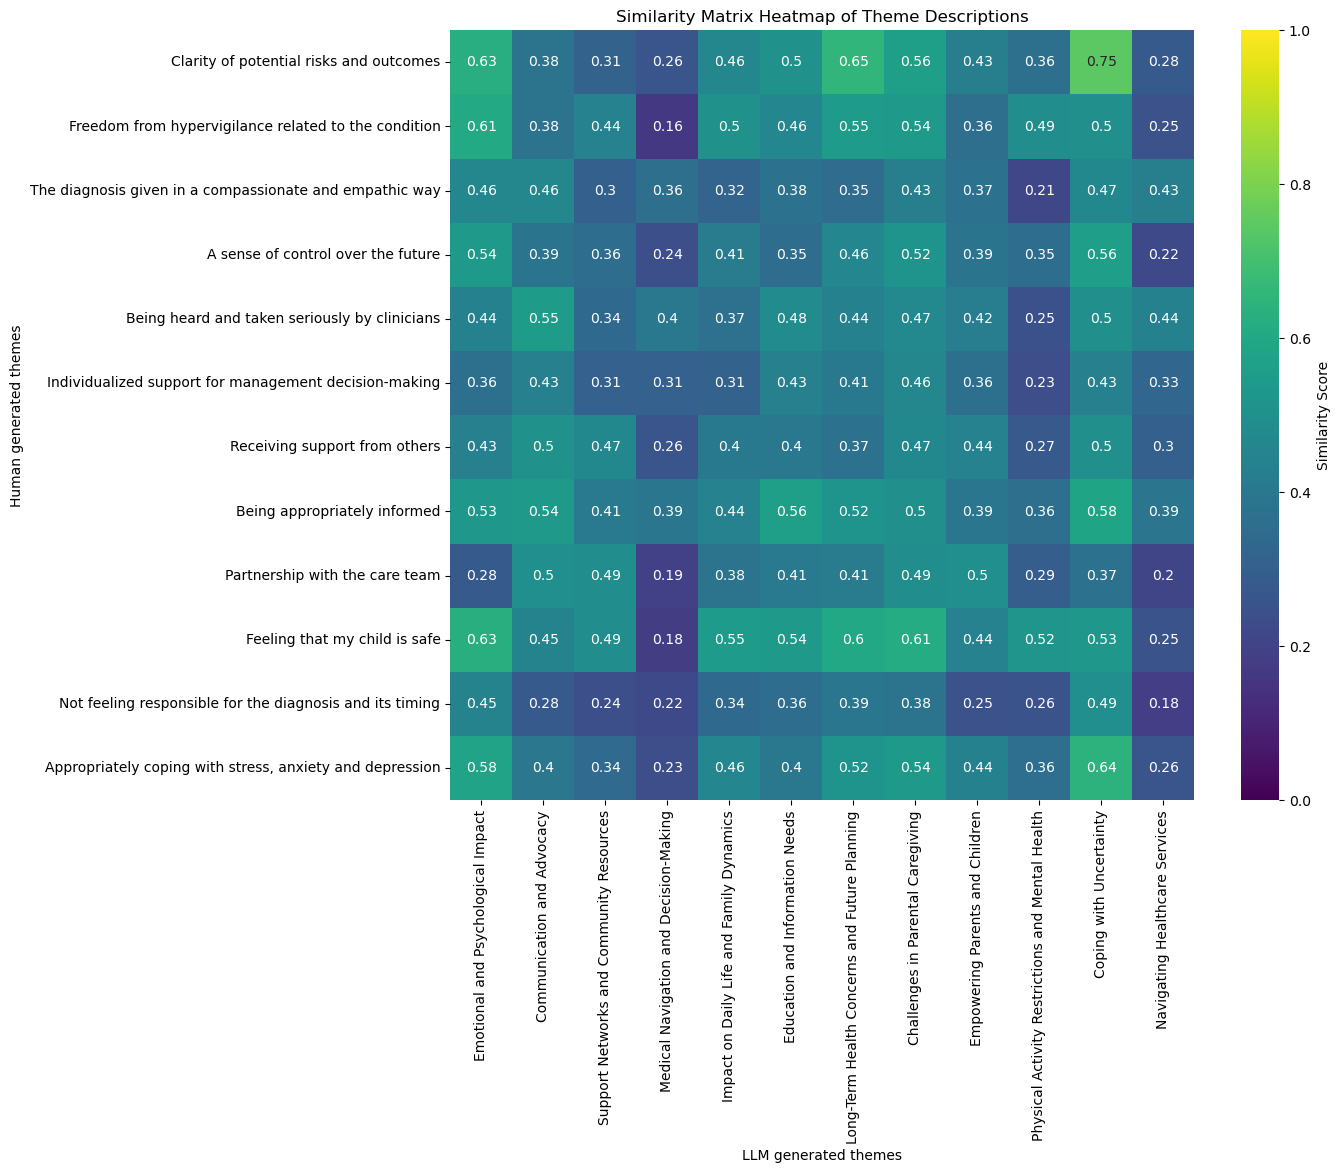

In [ ]:
model_name_eval = "all-MiniLM-L6-v2"
model = SentenceTransformer('all-MiniLM-L6-v2')

human_desc_embeddings = model.encode(df_human_themes['Description'].tolist(), convert_to_tensor=True)
llm_desc_embeddings = model.encode(df_themes['Description'].tolist(), convert_to_tensor=True)

cosine_sim_matrix = util.pytorch_cos_sim(human_desc_embeddings,llm_desc_embeddings).numpy()

similarity_desc_df = pd.DataFrame(
    cosine_sim_matrix,
    index = df_human_themes['Theme'],
    columns = df_themes['Theme']
)
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('Similarity Matrix Heatmap of Theme Descriptions')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

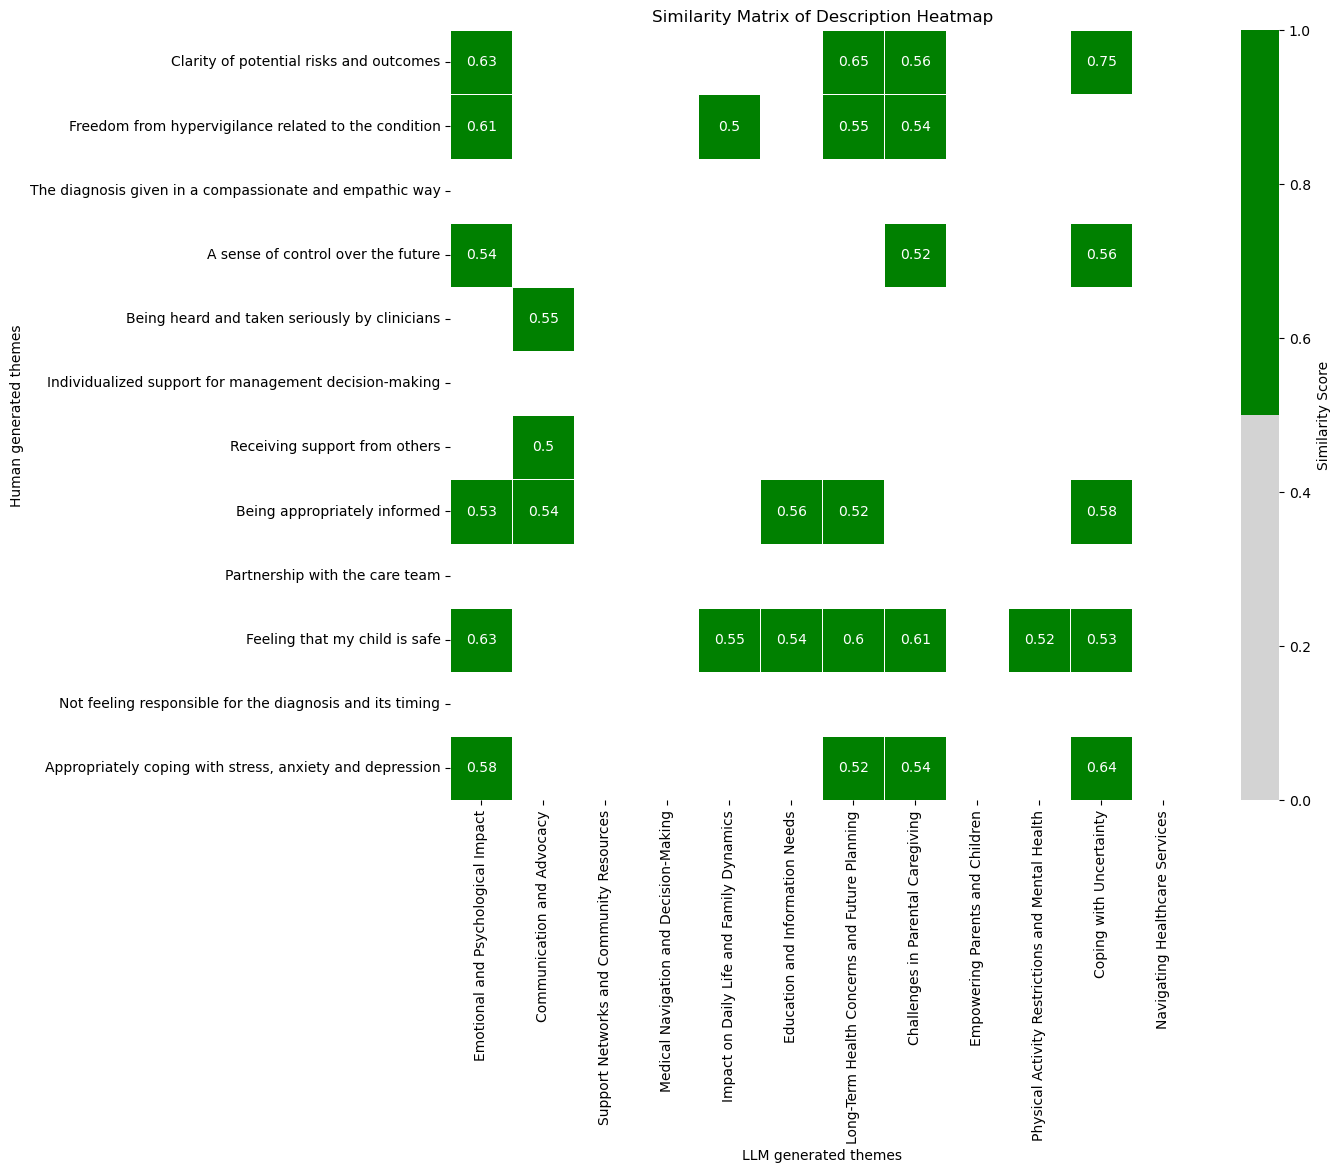

In [ ]:
threshold = np.quantile(similarity_desc_df, 0.80)
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_desc_df <= threshold),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('Similarity Matrix of Description Heatmap')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [ ]:
print(f'{model_name_eval} Threshold: {round(threshold,2)}')
similarity_array = similarity_desc_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array >= 0.5627)
percent_high = (high_similarity_count/total_cells)
print(f"Jarcard. {round(percent_high,3)}")

similarity_array = similarity_desc_df.to_numpy()
total_hit = np.sum(np.any(similarity_array >= 0.5627, axis=1).astype(int))
hit_rate = total_hit/len(df_human_themes)
print(f"Hit Rate. {round(hit_rate,3)}")

all-MiniLM-L6-v2 Threshold: 0.5
Jarcard. 0.069
Hit Rate. 0.417


## **LLM Based Evaluation**

In [ ]:
def format_rows(llm_row, human_row):
    text = ""
    text += f"LLM Theme: {llm_row['Theme']}, LLM Description: {llm_row['Description']}, Human Theme: {human_row['Theme']}, Human Description: {human_row['Description']} "

    return text

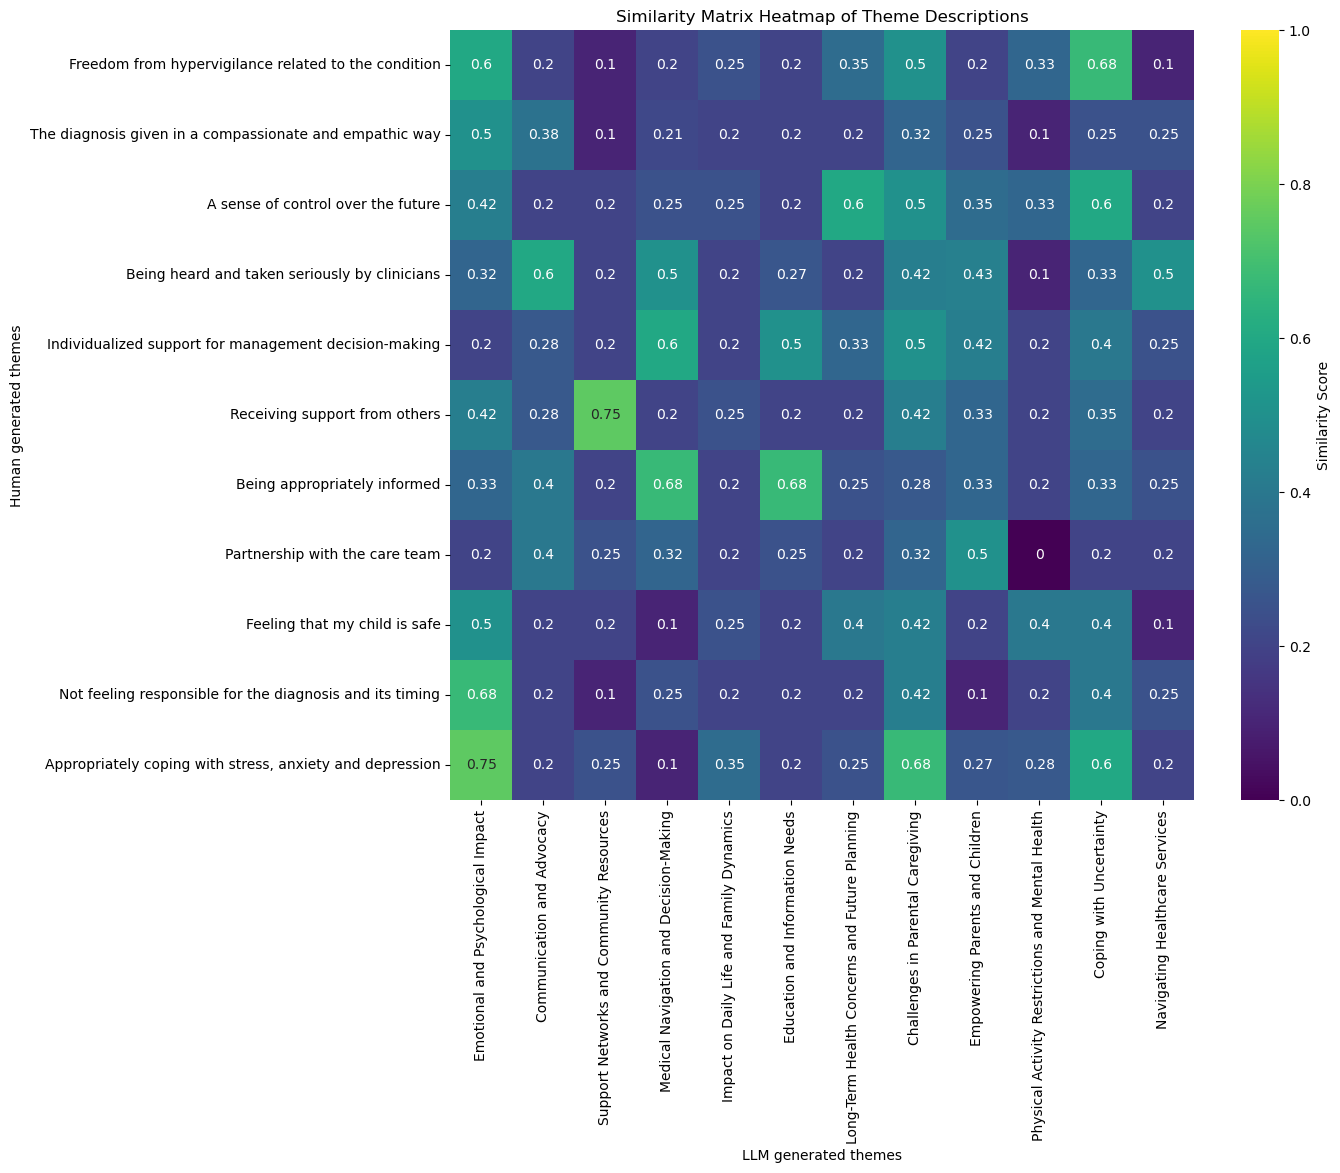

In [ ]:
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

model_name_eval = "GPT-4o-mini"


open_api_key = ""
import os
os.environ["OPENAI_API_KEY"]=open_api_key
model_name = "gpt-4o-mini"

model = ChatOpenAI(model_name = "gpt-4o-mini", temperature = 0)
parser = StrOutputParser()
prompt_template = """
You are a qualitative research expert performing inductive theme analysis.
Your goal is to evaluate the similarity between two theme pairs based on their names and descriptions provided in the text.
Carefully consider any overlapping concepts, keywords, ideas and the specificity when determining the similarity rating.
If one theme is very broad and the other is very specific, give some penalty to the similarity score.
Rate the similarity on a scale from 0 to 1, where 1 means they are identical and 0 means they are completely different.
text: {text}

For the output just give the similarity score as a number rounded to 3 decimals and nothing else.
Similarity Score:
"""
prompt = ChatPromptTemplate.from_template(prompt_template)
LLMchain = prompt | model | parser
similarity_matrix_llm = pd.DataFrame(index=df_human_themes['Theme'], columns=df_themes['Theme'])
for i, llm_row in df_human_themes.iterrows():
    for j, human_row in df_themes.iterrows():
        text = format_rows(llm_row, human_row)
        response = LLMchain.invoke({"text": text})
        similarity_score = float(response)
        similarity_matrix_llm.at[llm_row['Theme'], human_row['Theme']] = similarity_score
similarity_llm_df=similarity_matrix_llm.iloc[1:,:].astype(float)
plt.figure(figsize = (12,10))
sns.heatmap(similarity_llm_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('Similarity Matrix Heatmap of Theme Descriptions')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

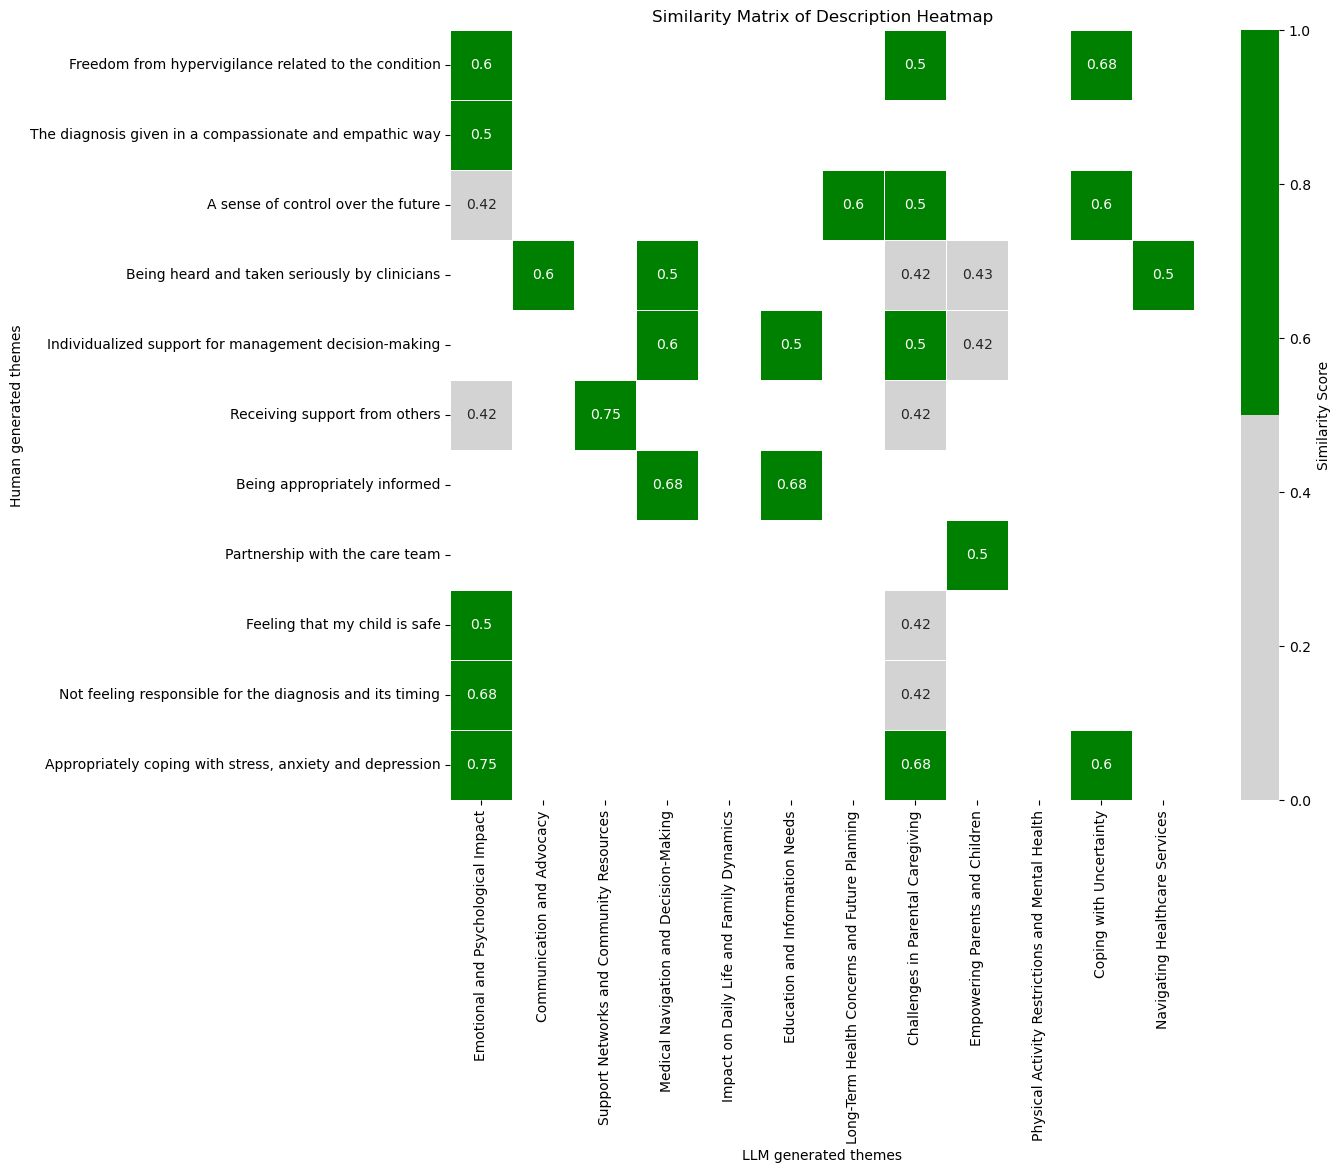

In [ ]:
from matplotlib.colors import ListedColormap
threshold = np.quantile(similarity_llm_df, 0.80)
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_llm_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_llm_df < threshold),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('Similarity Matrix of Description Heatmap')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [ ]:
print(f'{model_name_eval} Threshold: {round(threshold,2)}')
similarity_array = similarity_llm_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array >= .5)
percent_high = (high_similarity_count/total_cells)
print(f"Jarcard. {round(percent_high,3)}")

similarity_array = similarity_llm_df.to_numpy()
total_hit = np.sum(np.any(similarity_array >= .5, axis=1).astype(int))
hit_rate = total_hit/len(df_human_themes)
print(f"Hit Rate. {round(hit_rate,3)}")

GPT-4o-mini Threshold: 0.42
Jarcard. 0.167
Hit Rate. 0.917
